# CUR approximation в задаче сжатия нейронных сетей

## Загрузка нейронной сети

In [1]:
#%pip install matrix_fact

In [2]:
import pandas as pd
import torch
from itertools import product
from matplotlib import pyplot as plt
from torchvision import datasets, models, transforms
from tqdm import tqdm
from utils.common import *
from utils.cur_factorization import CUR

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
BATCH_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 5
LR = 1e-4
NUM_WORKERS = 4
WEIGHT_DECAY = 1e-5

In [4]:
vgg11 = models.vgg11()
vgg11

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

### Число параметров в разных слоях VGG-11.

In [5]:
total_params = count_parameters(vgg11)
nn_blocks = {
    "features" : vgg11.features,
    "avgpool" : vgg11.avgpool,
    "classifier" : vgg11.classifier
}
df = pd.DataFrame(
    index=nn_blocks.keys(),
    data={
        "num_features" : [ count_parameters(block) for block in nn_blocks.values() ],
        "%_features" : [ 100.0 * count_parameters(block) / total_params for block in nn_blocks.values() ]
    }
)
print(f"Total parameters for VGG11: {total_params}")
df

Total parameters for VGG11: 132863336


,num_features,%_features
features,9220480,6.939823
avgpool,0,0.000000
classifier,123642856,93.060177


## Адаптация модели под задачу

In [6]:
vgg11.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

Как можно заметить, большинство параметров в модели находится в слое-классификаторе, состоящем из полносвязных слоёв. Именно для них и будем применять разложения.

Сначала заменим слой-классификатор таким образом, чтобы число выходных слоёв модели совпадало с числом классов в нашей задаче. Для этого добавим ещё одну активацию и линейный слой с 10 выходами.

In [7]:
vgg11.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1))
vgg11.classifier = get_vgg11_classifier(num_classes=10)

### Цикл обучения

## Сжатие с помощью CUR decomposition

In [8]:
def extract_linear(model):
    model.to('cpu').eval()
    linear_num = 0
    linear_modules = []
    with torch.no_grad():
        for module in model.classifier.modules():
            if isinstance(module, torch.nn.Linear):
                print(module, module.weight.shape, type(module.weight))
                linear_num += 1
                linear_modules.append(module)
    return linear_num, linear_modules

### Замена полносвязных слоев

In [9]:
def get_compressed_classifier(compression, linear_num, linear_modules):
    compressed_classifier = torch.nn.Sequential()
    for i in range(linear_num):
        module = linear_modules[i]
        m = module.weight.data.size()[0]
        n = module.weight.data.size()[1]
        k = torch.round(m*n / (compression * (m + n)))
        rrank = (int)(k.numpy())
        crank = (int)(k.numpy())
        bias = module.bias.data
        
        if i + 1 != linear_num:
            cur_mdl = CUR(module.weight.data, k=-1, rrank=rrank, crank=crank)   
            cur_mdl.factorize()
            C_k, U_k = torch.from_numpy(cur_mdl.U).float(), torch.from_numpy(cur_mdl.S).float()
            compressed_classifier.append(CompressedLinear(C_k, U_k, bias))
            compressed_classifier.append(torch.nn.ReLU(inplace=True))
        else:
            compressed_classifier.append(module)
    return compressed_classifier

### Оценка качества сжатой сети

In [10]:
def evaluate(model, dataloader, start = 2, end = 100, step = 1):
    compression_params = torch.linspace(start=start, end=end, steps=(end - start)//step + 1)
    test_results = []
    parameters_num = []
    linear_num, linear_modules = extract_linear(model)
    for compression in compression_params:
        model.to('cpu')
        model.classifier = get_compressed_classifier(compression, linear_num, linear_modules)
        parameters = count_parameters(vgg11.classifier)
        parameters_num.append(parameters)
        test_results.append(test_model(vgg11, dataloader, DEVICE, False).cpu().item())
    return compression_params, test_results, parameters_num

### Отрисовка зависимости

In [11]:
def draw(compression_params, test_results):
    plt.plot(compression_params, test_results, color='blue')
    plt.xlim([1, 101])  
    plt.grid(True)
    plt.xlabel('Степнь сжатия')
    plt.ylabel('Accuracy')
    plt.title('Зависимость точности от степени сжатия')
    plt.show()

### Сохранение точности модели в зависимости от степени сжатия

In [12]:
def save(compression_params, test_accuracy, parameters_num, filename):
    df = pd.DataFrame({'compr' : compression_params.int(), 'accuracy' : test_accuracy,
                  'parameters' : parameters_num})
    df.to_csv(filename, index=False)

## Эксперименты с MNIST

### Загрузка данных

In [13]:
train_dataset, test_dataset = prepare_dataset("MNIST")

In [14]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False
)

### Отрисовка нескольких примеров из обучающей и тестовой выборок.

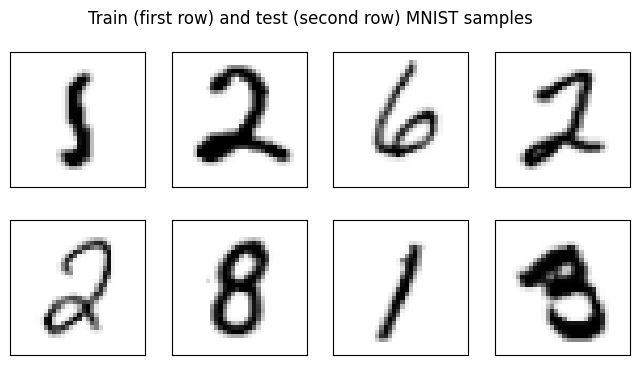

In [15]:
train_sample_ids = torch.randint(0, len(train_dataset), (4,))
test_sample_ids = torch.randint(0, len(test_dataset), (4,))

fig, ax = plt.subplots(2, 4, figsize=(8, 4))
fig.suptitle("Train (first row) and test (second row) MNIST samples")

for i, (train_id, test_id) in enumerate(zip(train_sample_ids, test_sample_ids)):
    ax[0, i].imshow(train_dataset[train_id][0][0, ...], cmap="Greys")
    ax[1, i].imshow(test_dataset[test_id][0][0, ...], cmap="Greys")

for i, j in product(range(2), range(4)):
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    
plt.show()

In [16]:
train_classification(vgg11, train_dataloader, epochs=EPOCHS, device=DEVICE, path="vgg11_mnist_state_dict")

Loss: 0.00474406685680151: 100%|██████████| 235/235 [00:21<00:00, 11.15it/s]  


In [17]:
test_model(vgg11, test_dataloader, device=DEVICE)

100%|██████████| 40/40 [00:01<00:00, 23.40it/s]

Correctly classified targets: 9922 / 10000
Total accuracy: 99.22000122070312%


tensor(99.2200, device='cuda:0')

In [18]:
compression_params, test_accuracy, parameters_num = evaluate(vgg11, test_dataloader)

Linear(in_features=25088, out_features=4096, bias=True) torch.Size([4096, 25088]) <class 'torch.nn.parameter.Parameter'>
Linear(in_features=4096, out_features=4096, bias=True) torch.Size([4096, 4096]) <class 'torch.nn.parameter.Parameter'>
Linear(in_features=4096, out_features=10, bias=True) torch.Size([10, 4096]) <class 'torch.nn.parameter.Parameter'>


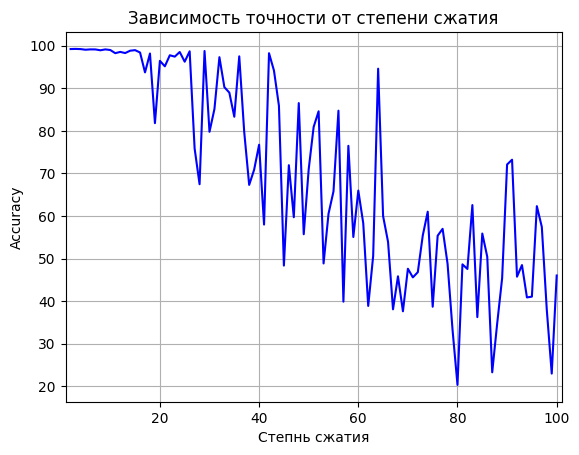

In [19]:
draw(compression_params, test_accuracy)

In [20]:
save(compression_params, test_accuracy, parameters_num, 'comp_acc_cur_mnist.csv')

## Эксперименты с CIFAR10

### Загрузка данных

In [21]:
train_dataset, test_dataset = prepare_dataset("CIFAR10")

Files already downloaded and verified
Files already downloaded and verified


In [22]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False
)

### Отрисовка нескольких примеров из обучающей и тестовой выборрок

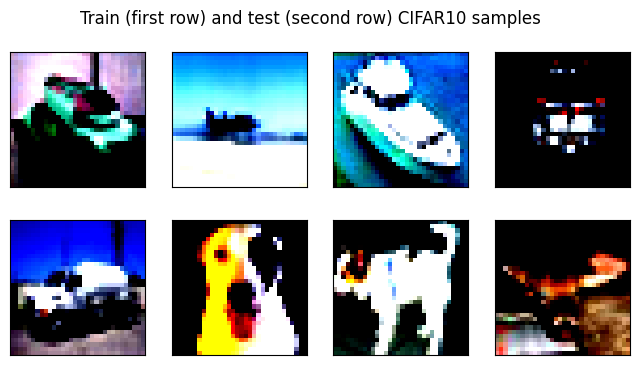

In [23]:
train_sample_ids = torch.randint(0, len(train_dataset), (4,))
test_sample_ids = torch.randint(0, len(test_dataset), (4,))

fig, ax = plt.subplots(2, 4, figsize=(8, 4))
fig.suptitle("Train (first row) and test (second row) CIFAR10 samples")

for i, (train_id, test_id) in enumerate(zip(train_sample_ids, test_sample_ids)):
    ax[0, i].imshow(train_dataset[train_id][0].permute(1, 2, 0))
    ax[1, i].imshow(test_dataset[test_id][0].permute(1, 2, 0))

for i, j in product(range(2), range(4)):
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    
plt.show()

In [24]:
vgg11 = models.vgg11()
vgg11.classifier = get_vgg11_classifier(num_classes=10)
train_classification(vgg11, train_dataloader, epochs=EPOCHS, device=DEVICE, path="vgg11_cifar10_state_dict")

Loss: 0.8628724217414856: 100%|██████████| 196/196 [00:17<00:00, 11.01it/s]


In [25]:
test_model(vgg11, test_dataloader, device=DEVICE)

100%|██████████| 40/40 [00:01<00:00, 26.55it/s]

Correctly classified targets: 6487 / 10000
Total accuracy: 64.8699951171875%


tensor(64.8700, device='cuda:0')

In [26]:
compression_params, test_accuracy, parameters_num = evaluate(vgg11, test_dataloader)

Linear(in_features=25088, out_features=4096, bias=True) torch.Size([4096, 25088]) <class 'torch.nn.parameter.Parameter'>
Linear(in_features=4096, out_features=4096, bias=True) torch.Size([4096, 4096]) <class 'torch.nn.parameter.Parameter'>
Linear(in_features=4096, out_features=10, bias=True) torch.Size([10, 4096]) <class 'torch.nn.parameter.Parameter'>


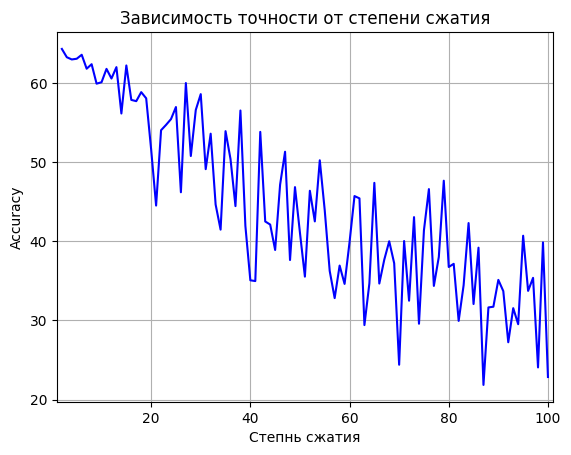

In [27]:
draw(compression_params, test_accuracy)

In [28]:
save(compression_params, test_accuracy, parameters_num, 'comp_acc_cur_cifar10.csv')